In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import time
from datetime import datetime, timezone
from okx.MarketData import MarketAPI 
import glob
import os

Средняя годовая доходность, %: 154.32
Средняя месячная доходность, %: 8.53
Средняя недельная доходность, %: 1.96
Сделок в год: 10084.40
Сделок в месяц: 884.60
Сделок в неделю: 205.80
Процент прибыльных сделок, %: 39.49
Покупки, %: 46.31
Продажи, %: 53.69
Средняя прибыль прибыльной сделки, %: 6.24
Средний убыток убыточной сделки, %: -2.56
Макс. прибыльная сделка, %: 142.55
Макс. убыточная сделка, %: -144.38
Макс. просадка, %: -7.04
Стд. откл. годовой pnl, %: 49.82
Стд. откл. месячной pnl, %: 5.81
Стд. откл. недельной pnl, %: 3.87
Коэффициент Шарпа: 3.66
Коэффициент Сортино: 18.08
Фактор восстановления: 1377.67


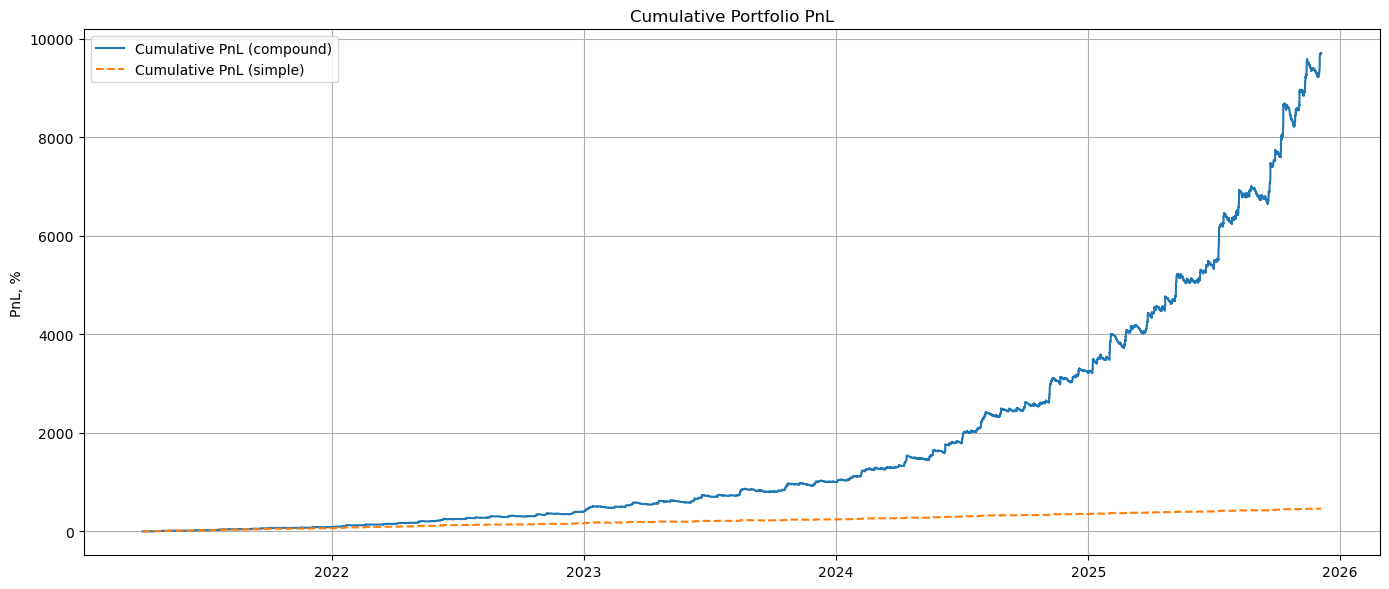

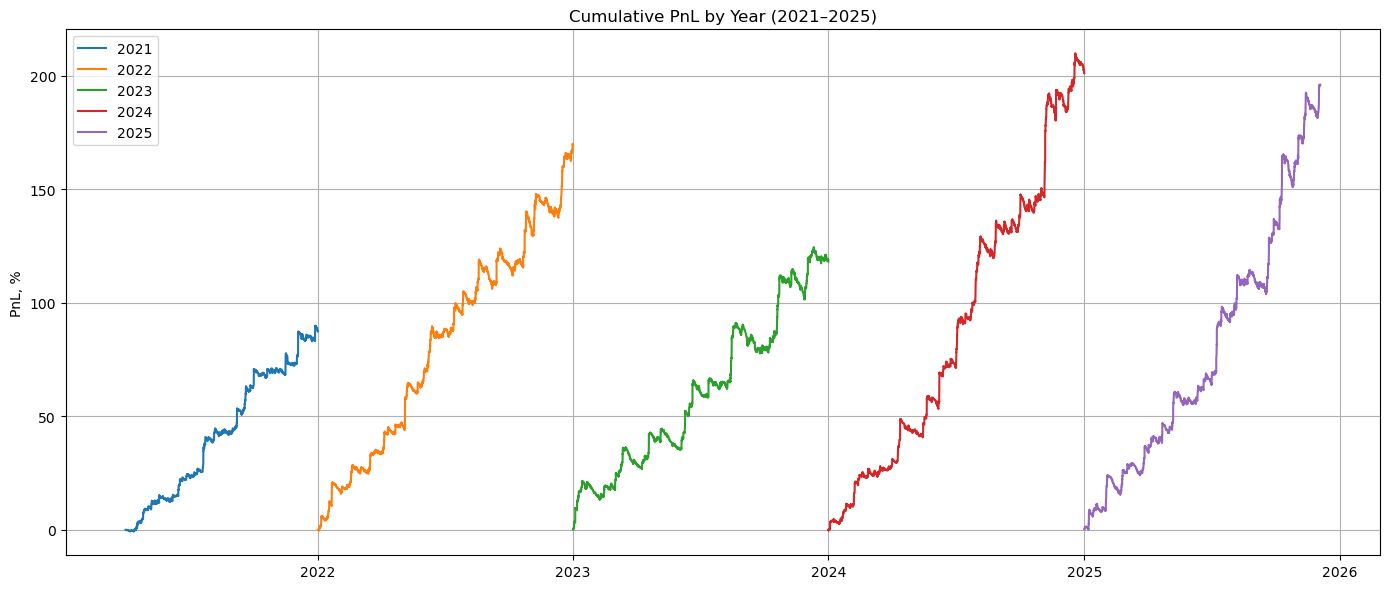

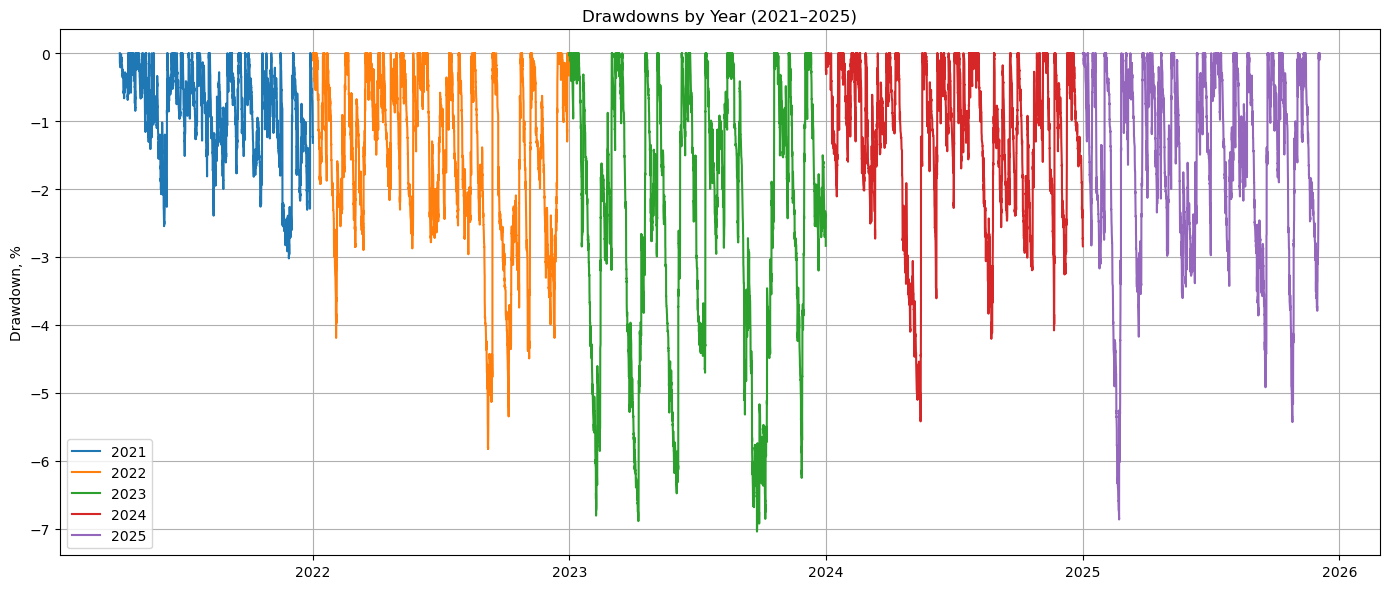


Ежегодная доходность (%):
year
2021     87.37
2022    169.12
2023    118.13
2024    201.05
2025    195.94
Name: profit_eq_pc, dtype: float64

Ежемесячная доходность (%):
month
2021-04     8.67
2021-05     4.43
2021-06     8.94
2021-07    13.15
2021-08     2.33
2021-09    14.26
2021-10     4.06
2021-11     1.87
2021-12     8.06
2022-01    17.52
2022-02     6.98
2022-03     6.34
2022-04     9.59
2022-05    13.41
2022-06    13.12
2022-07     8.04
2022-08     5.10
2022-09     1.30
2022-10     7.95
2022-11     3.24
2022-12    11.69
2023-01    16.20
2023-02     2.16
2023-03     8.82
2023-04     8.92
2023-05    -3.28
2023-06    18.31
2023-07     2.15
2023-08    15.46
2023-09    -5.43
2023-10    16.30
2023-11    -0.18
2023-12     4.62
2024-01     9.83
2024-02    13.66
2024-03     2.94
2024-04    11.83
2024-05     9.37
2024-06     9.63
2024-07    26.23
2024-08     7.75
2024-09     1.79
2024-10     4.76
2024-11    16.26
2024-12     3.62
2025-01    12.55
2025-02    11.29
2025-03     8.03
2025-04

In [14]:
df = pd.read_csv('deals_all_opt.csv', parse_dates=['entry_date', 'exit_date'])
df = df.sort_values('entry_date').reset_index(drop=True)

def cumulative_return(returns):
    """Кумулятивная доходность с учётом сложного процента"""
    return (1 + returns / 100).cumprod() - 1

def max_drawdown(cumret):
    """Максимальная просадка от пика кумулятивной доходности (%)"""
    peak = cumret.cummax()
    drawdown = (cumret - peak) / (1 + peak)
    return drawdown.min() * 100

def sharpe_ratio(returns, annual_factor=252):
    """Коэффициент Шарпа (годовой)"""
    if returns.std() == 0:
        return np.nan
    return returns.mean() / returns.std() * np.sqrt(annual_factor)

def sortino_ratio(returns, annual_factor=252):
    """Коэффициент Сортино (годовой)"""
    downside = returns[returns < 0]
    if len(downside) == 0 or downside.std() == 0:
        return np.nan
    return returns.mean() / downside.std() * np.sqrt(annual_factor)

def recovery_factor(cumret, max_dd):
    """Фактор восстановления = total_return / |max_drawdown|"""
    total_return = cumret.iloc[-1] * 100
    return total_return / abs(max_dd) if max_dd != 0 else np.nan


df['cum_pnl_compound'] = cumulative_return(df['profit_eq_pc'])
df['cum_pnl_simple'] = df['profit_eq_pc'].cumsum() / 100  #

# Макс. просадка
max_dd = max_drawdown(df['cum_pnl_compound'])

# Доходности по периодам
df['year'] = df['entry_date'].dt.year
df['month'] = df['entry_date'].dt.to_period('M')
df['week'] = df['entry_date'].dt.to_period('W')

# Группировка по периодам
yearly = df.groupby('year')['profit_eq_pc'].apply(lambda x: (1 + x / 100).prod() - 1) * 100
monthly = df.groupby('month')['profit_eq_pc'].apply(lambda x: (1 + x / 100).prod() - 1) * 100
weekly = df.groupby('week')['profit_eq_pc'].apply(lambda x: (1 + x / 100).prod() - 1) * 100

# Средние годовые/месячные/недельные доходности (%)
avg_annual = yearly.mean()
avg_monthly = monthly.mean()
avg_weekly = weekly.mean()

# Количество сделок
total_trades = len(df)
trades_per_year = total_trades / df['year'].nunique()
trades_per_month = total_trades / df['month'].nunique()
trades_per_week = total_trades / df['week'].nunique()

win_rate = (df['profit_abs'] > 0).mean() * 100

buy_ratio = (df['direction'] == 'Long').mean() * 100
sell_ratio = (df['direction'] == 'Short').mean() * 100

profitable = df[df['profit_abs'] > 0]['profit_eq_pc']
losing = df[df['profit_abs'] < 0]['profit_eq_pc']

avg_profit_trade = profitable.mean()*100
avg_loss_trade = losing.mean()*100
max_profit_trade = df['profit_eq_pc'].max()*100
max_loss_trade = df['profit_eq_pc'].min()*100


std_annual = yearly.std()
std_monthly = monthly.std()
std_weekly = weekly.std()

sharpe = sharpe_ratio(weekly.values, annual_factor=52)
sortino = sortino_ratio(weekly.values, annual_factor=52)


recovery = recovery_factor(df['cum_pnl_compound'], max_dd)

metrics = {
    "Средняя годовая доходность, %": avg_annual,
    "Средняя месячная доходность, %": avg_monthly,
    "Средняя недельная доходность, %": avg_weekly,
    "Сделок в год": trades_per_year,
    "Сделок в месяц": trades_per_month,
    "Сделок в неделю": trades_per_week,
    "Процент прибыльных сделок, %": win_rate,
    "Покупки, %": buy_ratio,
    "Продажи, %": sell_ratio,
    "Средняя прибыль прибыльной сделки, %": avg_profit_trade,
    "Средний убыток убыточной сделки, %": avg_loss_trade,
    "Макс. прибыльная сделка, %": max_profit_trade,
    "Макс. убыточная сделка, %": max_loss_trade,
    "Макс. просадка, %": max_dd,
    "Стд. откл. годовой pnl, %": std_annual,
    "Стд. откл. месячной pnl, %": std_monthly,
    "Стд. откл. недельной pnl, %": std_weekly,
    "Коэффициент Шарпа": sharpe,
    "Коэффициент Сортино": sortino,
    "Фактор восстановления": recovery,
}

for k, v in metrics.items():
    print(f"{k}: {v:.2f}" if isinstance(v, (int, float)) else f"{k}: {v}")


plt.figure(figsize=(14, 6))
plt.plot(df['entry_date'], df['cum_pnl_compound'] * 100, label='Cumulative PnL (compound)')
plt.plot(df['entry_date'], df['cum_pnl_simple'] * 100, label='Cumulative PnL (simple)', linestyle='--')
plt.title('Cumulative Portfolio PnL')
plt.ylabel('PnL, %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Кумулятивная PnL по годам
plt.figure(figsize=(14, 6))
for year in range(2021, 2026):
    d = df[df['year'] == year].copy()
    if not d.empty:
        d['cum'] = cumulative_return(d['profit_eq_pc']) * 100
        plt.plot(d['entry_date'], d['cum'], label=str(year))
plt.title('Cumulative PnL by Year (2021–2025)')
plt.ylabel('PnL, %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Просадки по годам
plt.figure(figsize=(14, 6))
for year in range(2021, 2026):
    d = df[df['year'] == year].copy()
    if not d.empty:
        cum = cumulative_return(d['profit_eq_pc'])
        dd = (cum - cum.cummax()) / (1 + cum.cummax()) * 100
        plt.plot(d['entry_date'], dd, label=str(year))
plt.title('Drawdowns by Year (2021–2025)')
plt.ylabel('Drawdown, %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


print("\nЕжегодная доходность (%):")
print(yearly.round(2))
print("\nЕжемесячная доходность (%):")
print(monthly.round(2))


strategies = df['strategy_name'].unique()
strat_metrics = []

for strat in strategies:
    d = df[df['strategy_name'] == strat].copy()
    if d.empty:
        continue
    cum = cumulative_return(d['profit_eq_pc'])
    total_ret = cum.iloc[-1] * 100
    max_dd_s = max_drawdown(cum)
    rec_fact = recovery_factor(cum, max_dd_s)
    
    # Недельные доходности для Шарпа/Сортино
    d['week'] = d['entry_date'].dt.to_period('W')
    weekly_s = d.groupby('week')['profit_eq_pc'].apply(lambda x: (1 + x / 100).prod() - 1) * 100
    
    sharpe_s = sharpe_ratio(weekly_s.values, annual_factor=52)
    sortino_s = sortino_ratio(weekly_s.values, annual_factor=52)
    
    strat_metrics.append({
        'strategy': strat,
        'cum_pnl_%': total_ret,
        'trades': len(d),
        'max_drawdown_%': max_dd_s,
        'recovery_factor': rec_fact,
        'sharpe': sharpe_s,
        'sortino': sortino_s
    })

strat_df = pd.DataFrame(strat_metrics)
print("\nМетрики по стратегиям:")
print(strat_df.round(2))

In [ ]:
d.to_parquet('strategy_stats.parquet', index = False)
d

In [ ]:
TICKERS = df['instrument'].unique().tolist()
TICKERS 

In [ ]:
"""Используя API OKX получить 5m (будут долго скачиваться) или 15m (быстрее скачаются) ohlc-данные по
торговым парам портфеля (например, используя функцию get_history_candlesticks библиотеки python-okx или
же эндпоинт https://www.okx.com/docs-v5/en/#order-book-trading-market-data-get-candlesticks-history
официального REST API OKX для бессрочных фьючерсов) с 2021 года и построить плавающую кривую
доходности портфеля. Т.е. для лонговых открытых позиций плавающая pnl позиции будет profit_eq_pc =
((cur_market_price - open_price) * volume - commission) / start_equity. Для шортовых сделок плавающая pnl
позиции будет profit_eq_pc = ((open_price - cur_market_price) * volume - commission) / start equity"""

START_DATE = "2019-01-01 00:00:00"
END_DATE = "2026-01-30 23:59:59"

start_ts = int(datetime.fromisoformat(START_DATE).timestamp() * 1000)
end_ts = int(datetime.fromisoformat(END_DATE).timestamp() * 1000)

start_year = START_DATE[:4]
end_year = END_DATE[:4]

fieldnames = [
    "ticker", "timestamp", "datetime_utc",
    "open", "high", "low", "close", "volume"
]


def dt_to_timestamp_ms(dt_str: str) -> int:
    """Преобразует строку даты в timestamp (мс) в UTC"""
    dt = datetime.strptime(dt_str, "%Y-%m-%d %H:%M:%S")
    dt = dt.replace(tzinfo=timezone.utc)
    return int(dt.timestamp() * 1000)

def fetch_all_candles(inst_id: str, start_ts: int, end_ts: int, bar: str = "1m") -> list:
    """    
    Формат свечи OKX: [ts, open, high, low, close, vol, volCcy, volCcyQuote, confirm]
    """
    all_candles = []
    current_before = end_ts  
    limit = 100 
    requests_count = 0
    
    print(f"  Загрузка данных для {inst_id}...")
    
    while True:

        #time.sleep(0.05) 
        
        try:
            resp = market_api.get_history_candlesticks(
                instId=inst_id,
                bar=bar,
                after=str(current_before), 
                limit=str(limit)
            )
        except Exception as e:
            raise RuntimeError(f"Ошибка API при запросе {inst_id}: {str(e)}")
        
        requests_count += 1
        
        if resp["code"] != "0":
            raise RuntimeError(f"OKX API error for {inst_id} (code {resp['code']}): {resp.get('msg', 'unknown error')}")
        
        data = resp.get("data", [])
        if not data:
            break  
        
        for candle in data:
            ts = int(candle[0])
            if ts < start_ts:
                continue  # пропускаем свечи ДО начала диапазона
            if ts > end_ts:
                continue  # пропускаем свечи ПОСЛЕ конца диапазона
            all_candles.append(candle)
        
        earliest_ts = int(data[-1][0])
        if earliest_ts <= start_ts:
            break 
        
        current_before = earliest_ts - 1  #граница для следующего запроса

    all_candles.sort(key=lambda x: int(x[0]))
    
    print(f"  ✓ Загружено {len(all_candles)} свечей ({requests_count} API запросов)")
    return all_candles


def main():

    global market_api
    market_api = MarketAPI(flag="0")  # "0" = основная сеть, "1" = демо-сеть

    start_ts = dt_to_timestamp_ms(START_DATE)
    end_ts = dt_to_timestamp_ms(END_DATE)
    
    print(f"Запуск загрузки 1m OHLC данных")
    print(f"Период: {START_DATE} — {END_DATE} (UTC)")
    print(f"Тикеры: {', '.join(TICKERS)}\n")



CHUNK_SIZE = 1000

for ticker in TICKERS:

    output_filename = f"okx_1m_ohlc_data_{ticker}_{start_year}-{end_year}.csv"
    
    print(f"Обработка тикера: {ticker} → {output_filename}")
    
    try:
        candles = fetch_all_candles(ticker, start_ts, end_ts, bar="1m")
        
        if not candles:
            print(f"  ⚠ Пропущен {ticker}: нет данных в указанном диапазоне\n")
            continue
        
        with open(output_filename, "w", newline="", encoding="utf-8") as f:
            writer = csv.DictWriter(f, fieldnames=fieldnames)
            writer.writeheader()
            
            buffer = []
            rows_written = 0
            
            for candle in candles:
                ts = int(candle[0])
                dt_utc = datetime.fromtimestamp(ts / 1000, tz=timezone.utc).strftime("%Y-%m-%d %H:%M:%S")
                
                row = {
                    "ticker": ticker,
                    "timestamp": ts,
                    "datetime_utc": dt_utc,
                    "open": candle[1],
                    "high": candle[2],
                    "low": candle[3],
                    "close": candle[4],
                    "volume": candle[5],
                }
                buffer.append(row)
                
                if len(buffer) >= CHUNK_SIZE:
                    writer.writerows(buffer)
                    rows_written += len(buffer)
                    buffer = []

            if buffer:
                writer.writerows(buffer)
                rows_written += len(buffer)
            
            print(f"  ✓ Успешно записано {rows_written} строк в {output_filename}\n")


    
    except Exception as e:
        print(f"  ✗ Ошибка при обработке {ticker}: {str(e)}\n")
        import traceback
        traceback.print_exc()

        
    
    print(f"\n✅ Загрузка завершена!")
    print(f"Итого записано: {rows_written} строк в файл {output_filename}")
    print(f"Период: {START_DATE} — {END_DATE} UTC")
    print(f"Тикеры: {ticker}")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n⚠ Загрузка прервана пользователем")
    except Exception as e:
        print(f"\n❌ Критическая ошибка: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:

ohlc_dir = 'ML_Finmarkets'
all_series = []

for file in glob.glob(os.path.join(ohlc_dir, '*.csv')):
    df = pd.read_csv(file)
    ticker = df['ticker'].iloc[0]
    df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
    # Используем open как рыночную цену
    series = df.set_index('datetime_utc')['open'].rename(ticker)
    all_series.append(series)

# Объединяем все серии по времени (outer join — все временные точки)
combined = pd.concat(all_series, axis=1)

# Сортируем по времени
combined = combined.sort_index()

# Сохраняем в один CSV-файл
output_file = 'all_instruments_15m_open.csv'
combined.to_csv(output_file)

print(f"Объединено {combined.shape[1]} инструментов.")
print(f"Период: {combined.index.min()} → {combined.index.max()}")
print(f"Сохранено в: {output_file}")

Объединено 21 инструментов.
Период: 2020-12-31 21:00:00 → 2025-12-31 20:45:00
Сохранено в: all_instruments_15m_open.csv


Начальный капитал: 10000.0 USDT

РЕЗУЛЬТАТЫ АНАЛИЗА

🔹 ПЛАВАЮЩАЯ КРИВАЯ (с открытыми позициями):
  Итоговая доходность: 6751.87%
  Коэффициент Шарпа:   1.81
  Коэффициент Сортино: 2.18
  Фактор восстановления: 191.88
  Макс. просадка:       35.19%

🔹 ФИКСИРОВАННАЯ КРИВАЯ (только закрытые сделки):
  Итоговая доходность: 6751.87%
  Коэффициент Шарпа:   3.74
  Коэффициент Сортино: 6.22
  Фактор восстановления: 847.05
  Макс. просадка:       7.97%

Момент максимальной просадки плавающей кривой: 2021-11-18 15:00:00
Плавающая доходность: 13.16%
Фиксированная доходность: 62.57%
Разница (открытые позиции): -49.41%

Количество открытых сделок в этот момент: 80
  DOGE-USDT-SWAP | Short | Cur price: 0.22716  0.377036 |Объём: 80.0 | PnL: 11.99 USDT
  ZIL-USDT-SWAP | Long | Cur price: 0.0899  0.100815 |Объём: 100.0 | PnL: -1.09 USDT
  RSR-USDT-SWAP | Long | Cur price: 0.034697  0.030578 |Объём: 100.0 | PnL: 0.41 USDT
  AAVE-USDT-SWAP | Short | Cur price: 269.36  319.85 |Объём: 0.01 | PnL: 0.50 USDT

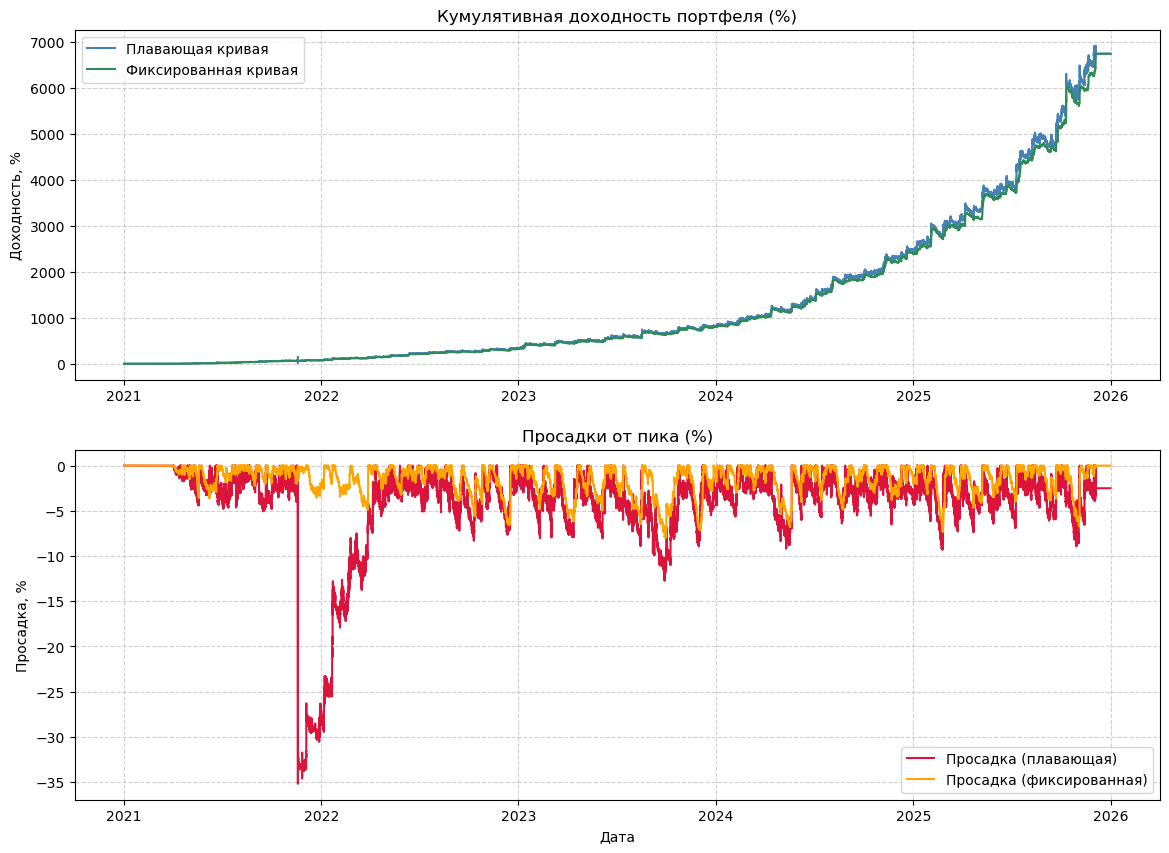

In [ ]:

deals = pd.read_csv('deals_all_opt.csv')
deals['entry_date'] = pd.to_datetime(deals['entry_date'], utc=True).dt.tz_localize(None)
deals['exit_date'] = pd.to_datetime(deals['exit_date'], utc=True, errors='coerce').dt.tz_localize(None)


prices = pd.read_csv('all_instruments_15m_open.csv')
prices.rename(columns={'datetime_utc': 'timestamp'}, inplace=True)
prices['timestamp'] = pd.to_datetime(prices['timestamp'], utc=True).dt.tz_localize(None)
prices.set_index('timestamp', inplace=True)


START_EQUITY = deals['start_equity'].iloc[0]
print(f"Начальный капитал: {START_EQUITY} USDT")



time_index = prices.index
portfolio = pd.DataFrame(index=time_index)
portfolio['fixed_pnl'] = 0.0
portfolio['floating_pnl'] = 0.0


if 'profit_abs' not in deals.columns:
    deals['profit_abs'] = deals['profit_eq_pc'] * deals['start_equity'] / 100

closed_deals = deals.dropna(subset=['exit_date']).copy()
events = []
for _, row in closed_deals.iterrows():

    try:
        pos = prices.index.get_indexer([row['exit_date']], method='pad')[0]
        if pos >= 0:
            t = prices.index[pos]
            events.append((t, row['profit_abs']))
    except Exception:
        continue

if events:
    events_df = pd.DataFrame(events, columns=['time', 'pnl']).set_index('time')
    events_agg = events_df.groupby(level=0).sum()
    portfolio.loc[events_agg.index, 'fixed_pnl'] = events_agg['pnl']
portfolio['fixed_pnl'] = portfolio['fixed_pnl'].cumsum()



# Для каждой сделки определяем период активности и добавляем плавающий PnL
for _, row in deals.iterrows():
    entry = row['entry_date']
    exit_time = row['exit_date'] if pd.notna(row['exit_date']) else time_index[-1]
    instrument = row['instrument']
    volume = row['volume']
    entry_price = row['entry_price']
    commission = row['commission']
    direction = row['direction']

    # Проверяем, есть ли такой инструмент в данных цен
    if instrument not in prices.columns:
        print(f"Инструмент {instrument} отсутствует в файле")
        continue

    # Маска активности сделки
    mask = (time_index >= entry) & (time_index <= exit_time)
    active_times = time_index[mask]
    if len(active_times) == 0:
        continue

    # Текущие цены
    current_prices = prices.loc[active_times, instrument]

    if direction == 'Long':
        pnl_values = ((current_prices - entry_price) * volume - commission)
    elif direction == 'Short':
        pnl_values = ((entry_price - current_prices) * volume - commission)
    else:
        continue

    portfolio.loc[active_times, 'floating_pnl'] += pnl_values

# Общая прибыль портфеля = закрытая прибыль + текущая стоимость открытых позиций
portfolio['total_pnl'] = portfolio['fixed_pnl'] + portfolio['floating_pnl']

# Доходность в %
portfolio['total_return_pct'] = portfolio['total_pnl'] / START_EQUITY * 100
portfolio['fixed_return_pct'] = portfolio['fixed_pnl'] / START_EQUITY * 100


def calculate_drawdown_from_return(cum_return_pct):
    equity = 1 + cum_return_pct / 100.0
    running_max = equity.cummax()
    drawdown = np.where(running_max > 0, (equity - running_max) / running_max, 0.0)
    return drawdown * 100

def recovery_factor_from_return(cum_return_pct):
    total_ret = cum_return_pct.iloc[-1]
    dd = calculate_drawdown_from_return(cum_return_pct)
    max_dd = -dd.min()
    if max_dd <= 0:
        return np.inf
    return total_ret / max_dd

def sharpe_ratio(returns, periods_per_year=365*24*4):
    ret = returns.dropna()
    if len(ret) < 2 or ret.std() == 0:
        return 0.0
    return ret.mean() / ret.std() * np.sqrt(periods_per_year)

def sortino_ratio(returns, periods_per_year=365*24*4):
    ret = returns.dropna()
    downside = ret[ret < 0]
    if len(ret) < 2 or len(downside) == 0 or downside.std() == 0:
        return np.inf
    return ret.mean() / downside.std() * np.sqrt(periods_per_year)

# Доходности за период (разности в %)
portfolio['total_ret_diff'] = portfolio['total_return_pct'].diff().fillna(0)
portfolio['fixed_ret_diff'] = portfolio['fixed_return_pct'].diff().fillna(0)

#  Плавающая кривая ---
dd_flt = calculate_drawdown_from_return(portfolio['total_return_pct'])
max_dd_flt = -dd_flt.min()
rf_flt = recovery_factor_from_return(portfolio['total_return_pct'])
sharpe_flt = sharpe_ratio(portfolio['total_ret_diff'])
sortino_flt = sortino_ratio(portfolio['total_ret_diff'])

# Фиксированная кривая ---
dd_fix = calculate_drawdown_from_return(portfolio['fixed_return_pct'])
max_dd_fix = -dd_fix.min()
rf_fix = recovery_factor_from_return(portfolio['fixed_return_pct'])
sharpe_fix = sharpe_ratio(portfolio['fixed_ret_diff'])
sortino_fix = sortino_ratio(portfolio['fixed_ret_diff'])


print("\n" + "="*50)
print("РЕЗУЛЬТАТЫ АНАЛИЗА")
print("="*50)

print("\n🔹 ПЛАВАЮЩАЯ КРИВАЯ (с открытыми позициями):")
print(f"  Итоговая доходность: {portfolio['total_return_pct'].iloc[-1]:.2f}%")
print(f"  Коэффициент Шарпа:   {sharpe_flt:.2f}")
print(f"  Коэффициент Сортино: {sortino_flt:.2f}")
print(f"  Фактор восстановления: {rf_flt:.2f}")
print(f"  Макс. просадка:       {max_dd_flt:.2f}%")

print("\n🔹 ФИКСИРОВАННАЯ КРИВАЯ (только закрытые сделки):")
print(f"  Итоговая доходность: {portfolio['fixed_return_pct'].iloc[-1]:.2f}%")
print(f"  Коэффициент Шарпа:   {sharpe_fix:.2f}")
print(f"  Коэффициент Сортино: {sortino_fix:.2f}")
print(f"  Фактор восстановления: {rf_fix:.2f}")
print(f"  Макс. просадка:       {max_dd_fix:.2f}%")


plt.figure(figsize=(14, 10))

# Доходность
plt.subplot(2, 1, 1)
plt.plot(portfolio.index, portfolio['total_return_pct'], label='Плавающая кривая', color='steelblue')
plt.plot(portfolio.index, portfolio['fixed_return_pct'], label='Фиксированная кривая', color='seagreen')
plt.title('Кумулятивная доходность портфеля (%)')
plt.ylabel('Доходность, %')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Просадки
plt.subplot(2, 1, 2)
plt.plot(portfolio.index, dd_flt, label='Просадка (плавающая)', color='crimson')
plt.plot(portfolio.index, dd_fix, label='Просадка (фиксированная)', color='orange')
plt.title('Просадки от пика (%)')
plt.ylabel('Просадка, %')
plt.xlabel('Дата')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
